# COGS 108 - Final Project 

# Overview

*Fill in your overview here*

# Names

- Kartik Bhatnagar
- Kai-Chin Shih 
- Sahana Srinivasan
- (Isaac) Fangzheng Xie 
- (Gin) Xiaojin Zheng 

# Group Members IDs

- 
- A12879790
- 
- 
- 

# Research Question

Are candidantes' trendiness on search engines, particularly Google, indicative of fundraising results?

## Background and Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis

Search engine trendiness figures positively correlate to campaign donorship.

# Dataset(s)

- Dataset 1 Name: BernieTrend.csv
- Link to the dataset: https://trends.google.com/trends/explore?q=%2Fm%2F01_gbv&geo=US
- Number of observations: 128 dates

- Dataset 2 Name: BernieTrend.csv
- Link to the dataset: https://trends.google.com/trends/explore?q=%2Fm%2F01_gbv&geo=US
- Number of observations: 28170 transactions

- How we plan on combining datasets:

# Setup

In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

# Data Cleaning

In [13]:
df_bernieTrend = pd.read_csv('bernietrend.csv')
df_bernieTrend.columns = ['date','trend']
df_bernieTrend = df_bernieTrend.drop([0], axis = 0)
df_bernieTrend['trend'] = df_bernieTrend['trend'].apply(pd.to_numeric, errors = 'coerce')
df_bernieTrend['date'] = df_bernieTrend['date'].astype('datetime64')

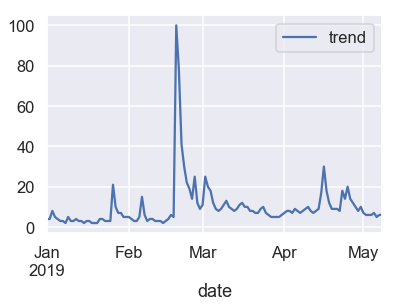

In [4]:
df_bernieTrend.plot(x='date', y='trend')

In [11]:
df_bernieFEC = pd.read_csv('FEC_Bernie2020.csv')
df_bernieFEC = df_bernieFEC[['transaction_id', 'contribution_receipt_date', 'contribution_receipt_amount', 'contributor_state']]
df_bernieFEC['contribution_receipt_date'] = df_bernieFEC['contribution_receipt_date'].astype("datetime64")
df_bernieFEC['contribution_receipt_amount'] = df_bernieFEC['contribution_receipt_amount'].apply(pd.to_numeric)

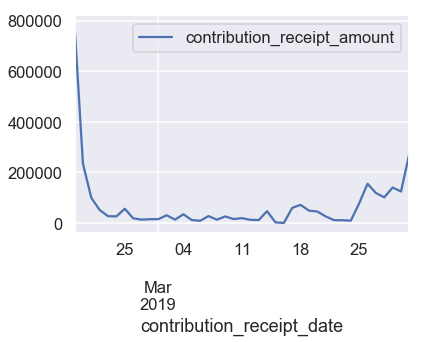

In [6]:
df_bernieTotalAmount = pd.pivot_table(df_bernieFEC, index=['contribution_receipt_date'],values=["contribution_receipt_amount"],aggfunc=np.sum)
df_bernieTotalAmount.plot()

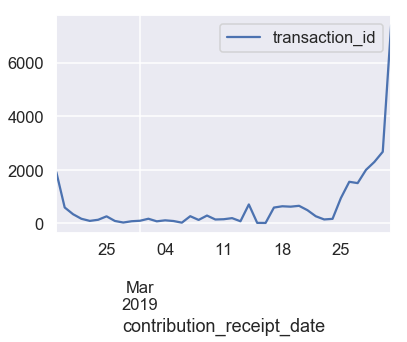

In [7]:
df_bernieTotalDonors = pd.pivot_table(df_bernieFEC, index=['contribution_receipt_date'],values=["transaction_id"],aggfunc=lambda x: len(x.unique()))
df_bernieTotalDonors.plot()

# Data Analysis & Results

Correlation between interest over time and number of unique donors

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*